In [1]:
# External dependencies
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed for replicability 
# np.random.seed(42)

In [401]:
def simulate_mean_reverting_jump_diffusion_process(
    theta: float, 
    mu: float, 
    sigma: float, 
    jump_arrival_rate: float,
    jump_mu: float, 
    jump_sigma: float, 
    n_points: int = 1000, 
    dt: int = 1
) -> np.ndarray:

    # Initialize mean-reverting jump diffusion stochastic process
    spread = [mu]

    for t in range(1, n_points):

        # Deterministic mean-reverting term
        mean_reverting = theta * (mu - spread[-1]) * dt
        
        # Brownain motion diffusion term
        diffusion = sigma * np.sqrt(dt) * np.random.normal()
        
        # Jump term
        if np.random.rand() < jump_arrival_rate * dt:  
            jump = np.random.normal(loc=jump_mu, scale=jump_sigma)
        else:
            jump = 0.0

        # Update spread
        spread.append(spread[-1] + mean_reverting + diffusion + jump)

    return np.array(spread)

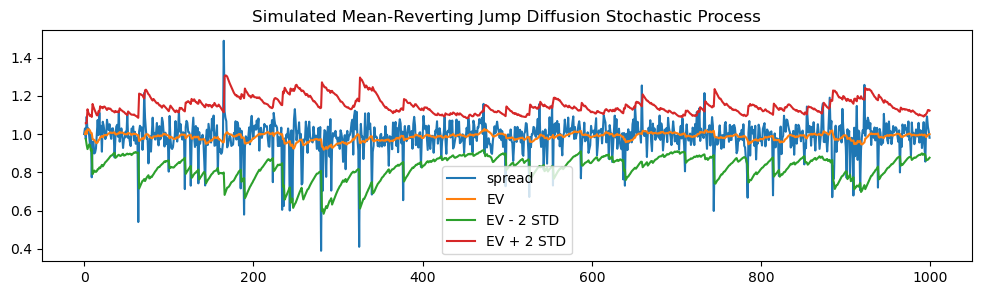

In [402]:
# Simulate a theoretical spread
spread: np.ndarray = simulate_mean_reverting_jump_diffusion_process(
    theta=0.90, 
    mu=1.00,
    sigma=0.05,
    jump_arrival_rate=0.10, 
    jump_mu=-0.10,
    jump_sigma=0.20, 
    n_points=1000
)
halflife: int = 10
expected_value: np.ndarray = pd.Series(spread).shift(1).ewm(halflife=halflife).mean()
lower_band: np.ndarray = expected_value - 2 * pd.Series(spread).shift(1).ewm(halflife=halflife).std()
upper_band: np.ndarray = expected_value + 2 * pd.Series(spread).shift(1).ewm(halflife=halflife).std()

plt.figure(figsize=(12, 3))
plt.plot(spread, label="spread")
plt.plot(expected_value, label="EV")
plt.plot(lower_band, label="EV - 2 STD")
plt.plot(upper_band, label="EV + 2 STD")
plt.title("Simulated Mean-Reverting Jump Diffusion Stochastic Process")
plt.legend()
plt.show()

In [ ]:
from typing import Optional

import numpy as np
from scipy.stats import norm


class JumpDiffusionCalibrator:
    """
    A class for calibrating a mean-reverting jump diffusion process defined by:
    
        dX_t = θ(μ - X_t)dt + σdW_t + J_t * dN_t

    The class performs the following steps:
    1. Estimates μ (long-term mean).
    2. Estimates θ (mean-reversion speed) using OLS/AR(1).
    3. Estimates σ (diffusion volatility) using residuals of the AR(1) model.
    4. Estimates λ (jump intensity) using jump counts.
    5. Estimates jump size distribution using observed jumps.
    """

    def __init__(self, spread: np.ndarray, dt: int) -> None:
        
        self.dt = dt
        self.spread = spread

        self.mu: Optional[float] = None
        self.theta: Optional[float] = None
        self.sigma: Optional[float] = None
        self.lambda_: Optional[float] = None
        self.jump_std: Optional[float] = None
        self.jump_mean: Optional[float] = None

        return

    def _estimate_mu(self, method: str = "empirical", lambda_: float = 0.95) -> float:
        """
        Estimates the long-term mean (μ) of the spread.

        Parameters:
        -----------
        method: str, default="ewma"
            Method for estimating μ. Options are "empirical" (mean of the spread)
            or "ewma" (exponentially weighted moving average).
        lambda_: float, default=0.95
            Decay factor for the EWMA method.

        Returns:
        --------
        float
            Estimated μ.
        """
        
        if method == "empirical":
            self.mu = np.mean(self.spread)
        elif method == "ewma":
            mu_ewma = self.spread[0]
            for s in self.spread[1:]:
                mu_ewma = lambda_ * s + (1 - lambda_) * mu_ewma
            self.mu = mu_ewma
        else:
            raise ValueError("Unsupported method for μ estimation.")
        
        return self.mu

    def _demean(self) -> np.ndarray:
        """
        Demeans the sample by subtracting μ from it.
        
        Returns:
        --------
        np.ndarray
            Demeaned spread.
        """

        if self.mu is None:
            raise ValueError("You must estimate μ before demeaning the spread.")
        
        return self.spread - self.mu

    def _estimate_theta(self) -> float:
        """
        Estimates the mean-reversion speed (θ) using the AR(1) model.

        Explanation:
        ------------
        The discretized solution for the mean-reverting process is:
            X_t+1 = X_t + θ(μ - X_t)Δt + σ√Δt * Z_t
        
        Rearranging and abstracting the diffusion term:
            X_t+1 - X_t = θ(μ - X_t)Δt + noise
        
        If we demean the spread, μ cancels out:
            X_t+1 - X_t = -θX_tΔt + noise
        
        For small Δt, this resembles an AR(1) process that follows:
            X_t+1 = (X_t -θX_t) + noise = (1 - θ)X_t + noise
        
        Fitting OLS to X_t+1 = β * X_t + error, we solve for θ as:
            θ = 1 - β.

        Returns:
        --------
        float
            Estimated θ.
        """

        # Lagged spread - must demean to estimate rate of mean reversion
        X = self.spread[:-1] - self.spread[:-1].mean()  # TODO: replace with self.mu estimators

        # Current spread
        y = self.spread[1:] - self.spread[:-1]

        # Solve AR(1) process via OLS: X_t+1 = β * X_t + error
        beta = np.linalg.lstsq(a=np.reshape(X, newshape=(-1, 1)), b=y, rcond=None)[0][0]
        #  beta = sm.OLS(endog=y, exog=X).fit().params[0]
        
        # θ = 1 - β 
        # self.theta = 1 - beta

        # θ = 1 - β   # FIXED the mean reversion speed
        self.theta = -beta
        
        return self.theta

    def _estimate_sigma(self) -> None:
        """
        Estimates the diffusion volatility (σ) from residuals of the AR(1) model.

        Explanation:
        ------------
        The residuals of the AR(1) fit represent the noise component:
            X_t+1 = X_t + θ(μ - X_t) + ε_t
            ε_t = X_t+1 - X_t - θμ + θX_t = X_t+1 - (1 - θ)X_t - θμ
        
        Compute the standard deviation of the residuals, scaled by √Δt.

        Returns:
        --------
        float
            Estimated σ.
        """

        # Lagged spread
        X = self.spread[:-1]  
        
        # Current spread
        y = self.spread[1:] 

        # Calculate the residual with the estimators of θ and μ
        residuals = y - (1 - self.theta) * X - self.mu * self.theta
        
        # Estimate σ from the time-scaled standard deviation of the resiudal 
        self.sigma = np.std(residuals) / np.sqrt(self.dt)
        
        return self.sigma

    def _estimate_jump_params(self, jump_threshold: int = 3) -> None:
        """
        Estimates jump parameters: intensity (λ) and jump size distribution.

        Parameters:
        -----------
        jump_threshold : float, default=3
            Threshold (in standard deviations) to identify jumps.

        Returns:
        --------
        tuple
            Estimated (λ, jump_mean, jump_std).
        """

        residuals = self.spread[1:] - (1 - self.theta) * self.spread[:-1] - self.mu * self.theta
        jump_indices = np.abs(residuals) > jump_threshold * self.sigma
        jumps = residuals[jump_indices]
        
        self.lambda_ = len(jumps) / len(residuals)
        self.jump_mean = np.mean(jumps)
        self.jump_std = np.std(jumps)
        
        return self.lambda_, self.jump_mean, self.jump_std
    
    def fit(self) -> None:

        self._estimate_mu()
        self._estimate_theta()
        self._estimate_sigma()
        self._estimate_jump_params()

        return

    def simulate(self, n_steps: int) -> np.ndarray:
        """
        Simulate the jump diffusion process using calibrated parameters.

        Parameters:
        -----------
        n_steps : int
            Number of steps to simulate.

        Returns:
        --------
        np.ndarray
            Simulated process.
        """
        
        # Initialize simulation
        X = np.zeros(n_steps)
        X[0] = self.spread[0]
        
        for t in range(1, n_steps):            
            dW = np.random.normal(0, np.sqrt(self.dt))
            dN = np.random.poisson(self.lambda_ * self.dt)
            J = np.random.normal(self.jump_mean, self.jump_std) if dN > 0 else 0
            X[t] = X[t-1] + self.theta * (self.mu - X[t-1]) * self.dt + self.sigma * dW + J
        
        return np.array(X)

In [467]:
jump_diffusion_calibrator: JumpDiffusionCalibrator = JumpDiffusionCalibrator(spread=spread, dt=1)
jump_diffusion_calibrator.fit()

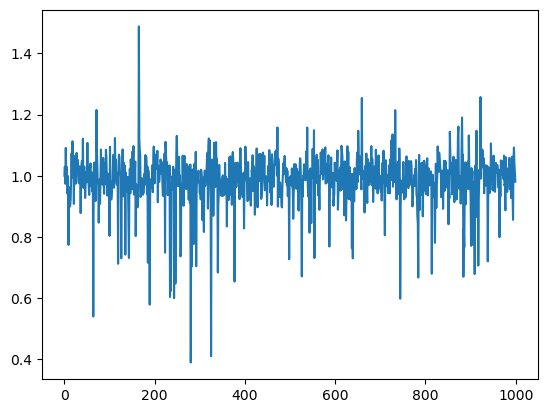

In [468]:
plt.plot(spread)

<Axes: >

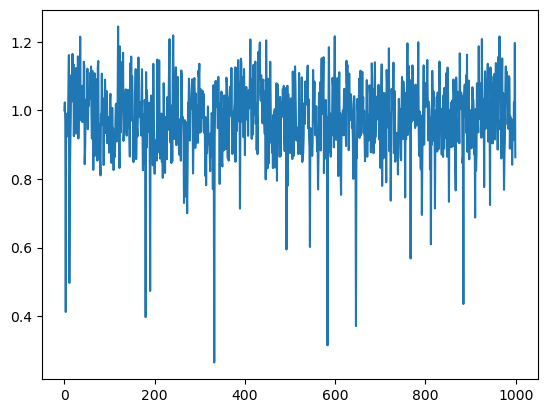

In [472]:
pd.Series(jump_diffusion_calibrator.simulate(n_steps=1_000)).plot()

In [473]:
jump_diffusion_calibrator.theta

0.9046796749728221

TODO: figure out if this is the best way to model the mean reversion dynamics 

In [460]:
import statsmodels.api as sm 

model = sm.OLS(endog=spread[1:]-spread[:-1], exog=(spread[:-1] - spread[:-1].mean())).fit()
model.params[0]

-0.9046796749728221

In [407]:
spread

array([1.        , 1.02920824, 0.97375305, 1.09098225, 1.01501227,
       1.02916486, 0.9881918 , 0.94040095, 0.99882174, 0.77400501,
       0.95067424, 0.96189943, 0.8985176 , 0.9039707 , 0.92573008,
       0.99603912, 1.07371309, 0.99439691, 1.1125645 , 0.99868516,
       1.0430126 , 0.90789188, 1.06443092, 1.04629569, 1.01243841,
       0.97386552, 0.98607845, 1.07480495, 1.04410859, 1.02123602,
       1.05153471, 0.99883822, 0.97526414, 1.02892815, 1.03049023,
       0.99717154, 0.87798222, 0.98397382, 1.03902559, 1.0483718 ,
       0.98623258, 1.12099021, 0.96030027, 0.99372587, 1.0297299 ,
       0.9982547 , 0.92736216, 0.97274317, 0.9815392 , 1.01253147,
       0.98584237, 1.10724903, 0.97940235, 0.9882914 , 0.96043227,
       0.93723245, 1.02812001, 1.02547423, 1.04043831, 0.96673117,
       1.01185466, 0.94926515, 0.95769747, 0.9844387 , 0.54016185,
       1.01507305, 1.04324612, 1.01812122, 1.03520622, 0.91749821,
       0.98300722, 1.21498591, 1.08487606, 1.0221887 , 0.97427